In [1]:
import numpy as np
import tensorflow as tf
from backend.self_gated_fast_weights_network import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import memory_tasks as mt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def relu(x):
    return np.maximum(x,0)

def state_to_out(s,w):
    return relu(s).dot(w['W_out'].T) + w['b_out']

In [3]:
mem_gap_length = 10

tag = 'xor_gfw9' #'ms_gfw2'
weights_path = '../weights/' + tag + '.npz'
trials_path = '../weights/' + tag + '_trials.npz'
    
#task params
input_wait = 20
stim_dur = 10
out_gap = 10 #20
out_dur = 60

var_delay_length = 50
var_in_wait = 0
var_out_gap = 0
second_in_scale = 1.  #Only one input period or two (e.g. mem saccade no distractor vs with distractor)
go_cue = True
task = 'xor'
name = 'xor_fixed'

#model params
n_in = 2 
N_rec = 50 
n_out = 2
#n_steps = 80 
tau = 100.0 #As double
dt = 10.0  #As double
dale_ratio = 0
rec_noise = 0.0
stim_noise = 0.01
batch_size = 128

#regularization
L2_firing_rate = .5


#train params
learning_rate = .0001 
training_iters = 500000
display_step = 20

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'
#weights_path = None

params = mt.set_params(epochs=200, sample_size= batch_size, input_wait=input_wait, 
                    stim_dur=stim_dur, mem_gap=mem_gap_length, out_gap = out_gap, out_dur=out_dur, 
                    N_rec=N_rec, n_out = n_out, n_in = n_in, 
                    var_delay_length=var_delay_length, go_cue = go_cue,
                    var_in_wait = var_in_wait, var_out_gap = var_out_gap,
                    rec_noise=rec_noise, stim_noise=stim_noise, 
                    dale_ratio=dale_ratio, dt=dt, tau=tau, task=task,
                    second_in_scale=second_in_scale,
                    L2_firing_rate=L2_firing_rate)

generator = mt.generate_train_trials(params)

In [4]:
#Fast Weight specific params
params['tau_fw'] = 500.       #initial time constant of fast_weights
params['W_gamma_train'] = True  #trainable gamma (dt/tu_fw)
params['b_gamma_train'] = True
params['phi_train'] = True    #trainable phi (sensitivity to fws)
params['global_phi'] = False  #Single global or synapse specific plasticity

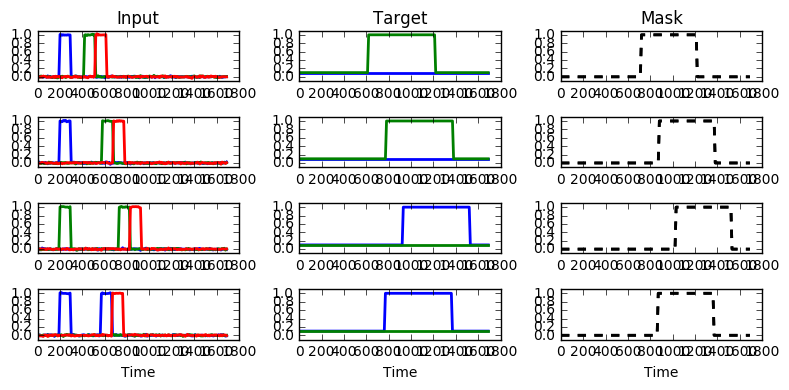

In [5]:
trial = mt.build_train_trials(params)
tt = np.arange(0,params['dt']*params['N_steps'],params['dt'])

plt.figure(figsize=(8,4))

for ii in range(4):
    plt.subplot(4,3,3*ii+1)
    plt.plot(tt,trial[0][ii,:,:],linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Input')
    
    plt.subplot(4,3,3*ii+2)
    plt.plot(tt,trial[1][ii,:,:],linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Target')
    
    plt.subplot(4,3,3*ii+3)
    plt.plot(tt,trial[2][ii,:,:],'k--',linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Mask')


plt.tight_layout()
plt.show()

In [6]:
model = Model(params)
sess = tf.Session()
t,fw,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
            save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

sess.close()

np.savez(trials_path, s=s, fw=fw, phi=phi, input_data=trial_data[0],target_data=trial_data[1], gamma=gamma)

Iter 2560, Minibatch Loss= 0.182626
Norm of Phi= 0.031471
Mean Gamma= 0.0200086
Var Gamma= 4.3904e-13
Norm of Grad Wrec= 0.00822724
Iter 5120, Minibatch Loss= 0.179913
Norm of Phi= 0.0645011
Mean Gamma= 0.0200362
Var Gamma= 1.38287e-11
Norm of Grad Wrec= 0.00895968
Iter 7680, Minibatch Loss= 0.176998
Norm of Phi= 0.100997
Mean Gamma= 0.0200833
Var Gamma= 1.17951e-10
Norm of Grad Wrec= 0.0122631
Iter 10240, Minibatch Loss= 0.173244
Norm of Phi= 0.149111
Mean Gamma= 0.0201625
Var Gamma= 6.67031e-10
Norm of Grad Wrec= 0.019074
Iter 12800, Minibatch Loss= 0.168136
Norm of Phi= 0.215178
Mean Gamma= 0.0203003
Var Gamma= 2.87056e-09
Norm of Grad Wrec= 0.0334763
Iter 15360, Minibatch Loss= 0.160148
Norm of Phi= 0.301606
Mean Gamma= 0.0205502
Var Gamma= 7.74219e-09
Norm of Grad Wrec= 0.0647633
Iter 17920, Minibatch Loss= 0.146022
Norm of Phi= 0.405097
Mean Gamma= 0.0210561
Var Gamma= 8.82628e-09
Norm of Grad Wrec= 0.133353
Iter 20480, Minibatch Loss= 0.126088
Norm of Phi= 0.521871
Mean Gamma= 0

(170, 128, 50, 50)
(128, 50)


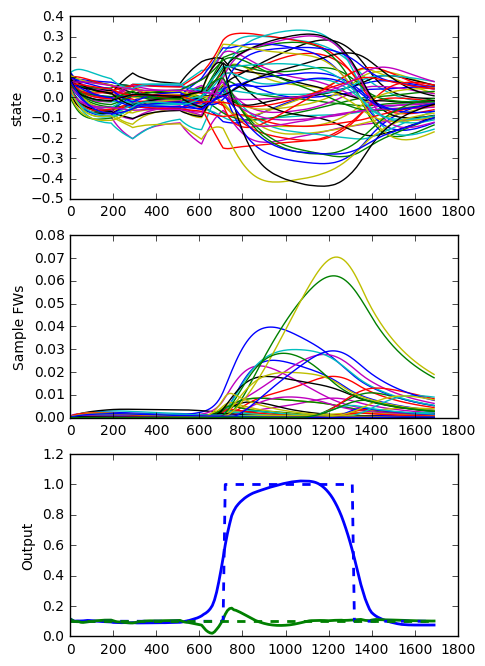

In [26]:
trials = np.load(trials_path)
w = np.load(weights_path)

s = trials['s']
fw = trials['fw']
trial_data = [trials['input_data'],trials['target_data']]
phi = trials['phi']
gamma = trials['gamma']

tt = np.arange(0,params['dt']*params['N_steps'],params['dt'])

print np.asarray(fw).shape
# print phi
print s[0].shape



fw_ = np.asarray(fw)
s_ = np.asarray(s)

trial_idx = 1

plt.figure(figsize=(5,8))

plt.subplot(3,1,1)
plt.plot(tt,s_[:,trial_idx,:])
plt.ylabel('state')

plt.subplot(3,1,2)
idx = np.random.randint(low=0,high=N_rec,size=[100,2])
for ii in range(len(idx)):
    plt.plot(tt,fw_[:,trial_idx,idx[ii,0],idx[ii,1]])

plt.ylabel('Sample FWs')

plt.subplot(3,1,3)
o = state_to_out(s_[:,trial_idx,:],w)
plt.plot(tt,o[:,0],'b',linewidth=2)
plt.plot(tt,o[:,1],'g',linewidth=2)
plt.plot(tt,trial_data[1][trial_idx,:,0],'b--',linewidth=2)
plt.plot(tt,trial_data[1][trial_idx,:,1],'g--',linewidth=2)
plt.ylabel('Output')

plt.show()

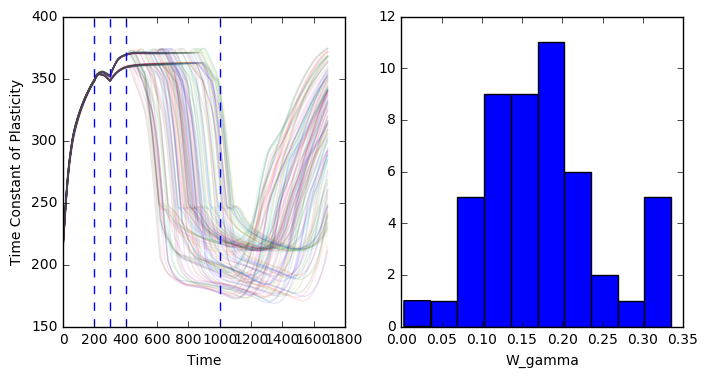

In [31]:
gamma_ = np.asarray(gamma)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tt,dt/gamma_[:,:,0],alpha=.1)

plt.axvline(params['dt']*input_wait,linestyle='--')
plt.axvline(params['dt']*(input_wait+stim_dur),linestyle='--')
plt.axvline(params['dt']*(input_wait+stim_dur+mem_gap_length),linestyle='--')
plt.axvline(params['dt']*(input_wait+2*stim_dur+mem_gap_length+var_delay_length),linestyle='--')

plt.ylabel('Time Constant of Plasticity')
plt.xlabel('Time')

plt.subplot(1,2,2)
plt.hist(w['W_gamma'])
plt.xlabel('W_gamma')

plt.show()

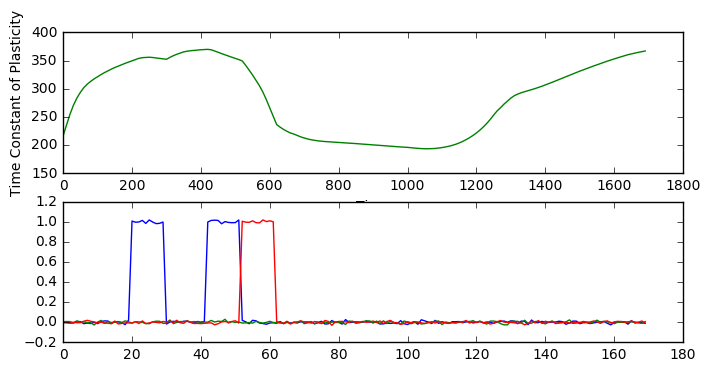

In [39]:
trial_idx = 3

plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(tt,dt/gamma_[:,trial_idx,0],'g',alpha=1)

# plt.axvline(params['dt']*input_wait,linestyle='--')
# plt.axvline(params['dt']*(input_wait+stim_dur),linestyle='--')
# plt.axvline(params['dt']*(input_wait+stim_dur+mem_gap_length),linestyle='--')
# plt.axvline(params['dt']*(input_wait+2*stim_dur+mem_gap_length+var_delay_length),linestyle='--')

plt.ylabel('Time Constant of Plasticity')
plt.xlabel('Time')

plt.subplot(2,1,2)
plt.plot(trial_data[0][trial_idx,:,:])

plt.show()

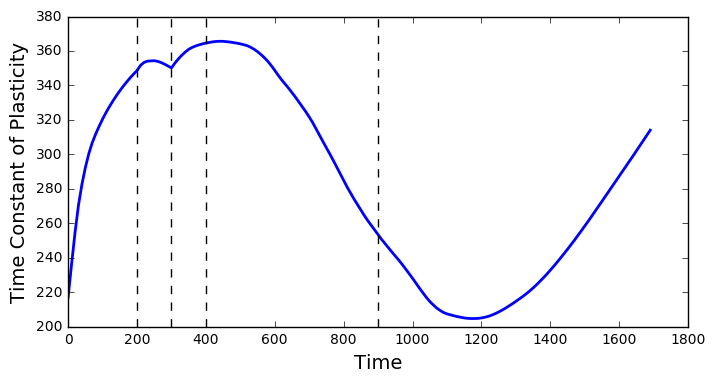

In [29]:
plt.figure(figsize=(8,4))
plt.plot(tt,np.mean(dt/gamma_[:,:,0],axis=1),'b',linewidth=2)
plt.axvline(params['dt']*input_wait,color='k',linestyle='--')
plt.axvline(params['dt']*(input_wait+stim_dur),color='k',linestyle='--')
plt.axvline(params['dt']*(input_wait+stim_dur+mem_gap_length),color='k',linestyle='--')
plt.axvline(params['dt']*(input_wait+stim_dur+mem_gap_length+var_delay_length),color='k',linestyle='--')

plt.ylabel('Time Constant of Plasticity',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.show()

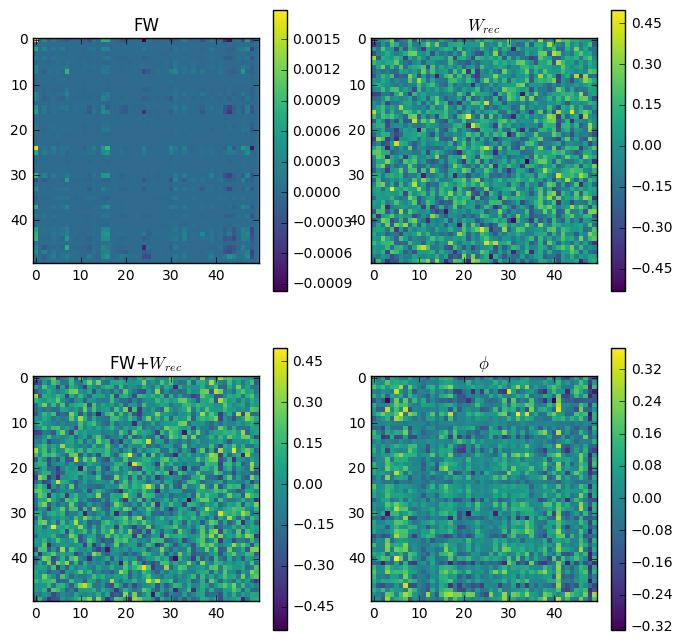

In [10]:


phi_ = phi

max_fw = np.argmax(np.sum(np.sum(np.sum(fw_,axis=3),axis=2),axis=1))

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(fw_[80,0,:,:]*phi_,interpolation='none')
plt.title('FW')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(w['W_rec'],interpolation='none')
plt.title('$W_{rec}$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(fw_[80,0,:,:]*phi_+w['W_rec'],interpolation='none')
plt.title('FW+$W_{rec}$')
plt.colorbar()
plt.subplot(2,2,4)
if phi.shape[0] != 1:
    plt.imshow(phi,interpolation='none')
    plt.title('$\phi$')
    plt.colorbar()

plt.show()

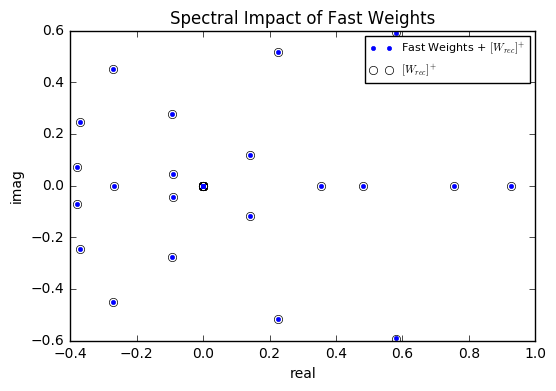

In [11]:
time = 50

part = s_[time,0,:]>0
w_eff = w['W_rec']*part

efw = np.linalg.eig((fw_[time,0,:,:]*part)*phi_+w_eff)[0]
e = np.linalg.eig(w_eff)[0]

plt.plot(efw.real,efw.imag,'.')
plt.plot(e.real,e.imag,'o',color='none')
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Spectral Impact of Fast Weights')
plt.legend(['Fast Weights + $[W_{rec}]^{+}$','$[W_{rec}]^{+}$'],fontsize=8)
plt.show()

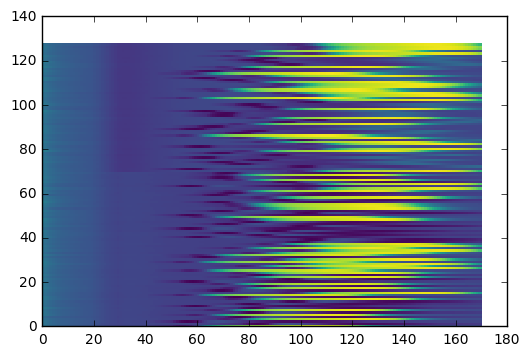

In [12]:
trial_data[1].shape
target = np.argmax(trial_data[1][:,-1,:],axis=1)
in1 = np.argmax(trial_data[0][:,25,:],axis=1)

plt.pcolormesh(s_[:,np.argsort(in1),7].T)
plt.show()

In [13]:
fw_.shape

(170, 128, 50, 50)

In [14]:
t/60.

168.12229741414387

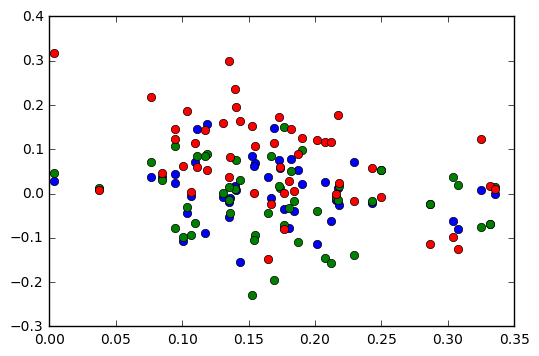

In [15]:

plt.plot(w['W_gamma'],w['W_in'][:,0],'o')
plt.plot(w['W_gamma'],w['W_in'][:,1],'o')
plt.plot(w['W_gamma'],w['W_in'][:,2],'o')
plt.show()

In [16]:
t/60

168.12229741414387